In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import ADASYN

from src.data_loader import load_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [2]:
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('seaborn-whitegrid')

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.svm import SVC
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, AdaBoostClassifier,
    RandomForestClassifier, SVC, ExtraTreesClassifier
]

## Cluster Oversampling using SMOTE

In [4]:
X = pd.read_csv('../data/castellX.csv')
y = pd.read_csv('../data/castelly.csv', header=None)[0]

In [5]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

bar_plot = []
for train_index, test_index in splitter.split(X, y):
    X_train, y_train = ADASYN(n_jobs=-1).fit_resample(X.iloc[train_index], y.iloc[train_index])
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    performances = []
    for Model in models:
        try:
            model = Model()
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            performances.append([
                Model.__name__, len(y_pred),
                sum(y_pred), sum(y_test),
                sum(y_test & y_pred),
                X_test[~y_pred & y_test]['volume'],
                classification_report(y_test, y_pred, output_dict=True)
            ])
        except Exception as e:
            pass
    bar_plot.append(performances)

In [6]:
THRESHOLD = 0.7

ground_truth = bar_plot[0][0][3]

tp_tfs, tp_tfs_err, tps, tps_err, f1s, f1s_err = [], [], [], [], [], []
for model_index, model in enumerate([e[0] for e in bar_plot[0]]):
    tp_fp, tp, f1 = [], [], []
    for split in bar_plot:
        tp_fp.append(split[model_index][2])
        tp.append(split[model_index][4])
        f1.append(split[model_index][-1]['True']['f1-score']) 

    tp_tfs.append(np.array(tp_fp).mean())
    tp_tfs_err.append(np.array(tp_fp).std())
    tps.append(np.array(tp).mean())
    tps_err.append(np.array(tp).std())
    
    if (tps[-1] / ground_truth) >= THRESHOLD:
        f1s.append(np.array(f1).mean())
        f1s_err.append(np.array(f1).std()) 
    else:
        f1s.append(0)
        f1s_err.append(0)

In [7]:
import pickle
with open('ADASYN.pickle', 'wb') as fh:
    pickle.dump(
        {
            'ground_truth': bar_plot[0][0][3],
            'tp_tfs': tp_tfs,
            'tp_tfs_err': tp_tfs_err,
            'tps': tps,
            'tps_err': tps_err,
            'labels': [e[0] for e in bar_plot[0]]
        }, fh
    )

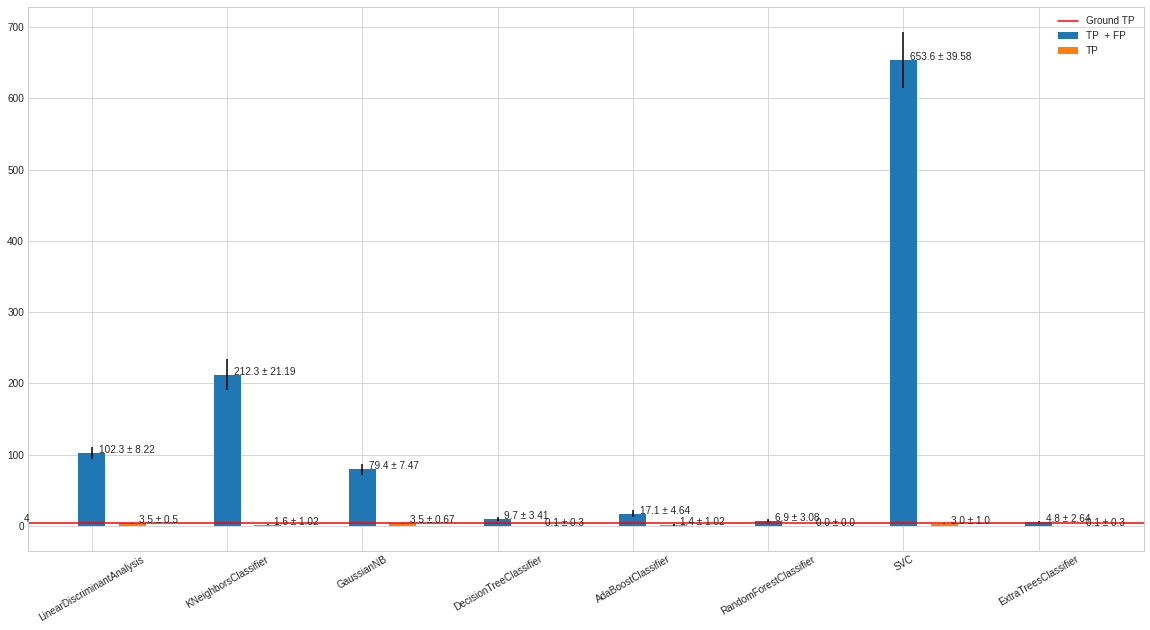

In [8]:
from src.utils.visualization import plot_trues

ground_truth = bar_plot[0][0][3]
labels = [e[0] for e in bar_plot[0]]
plot_trues(
    tps=tps, tps_tfs=tp_tfs, gt=ground_truth,
    labels=labels, tps_err=tps_err, tps_tfs_err=tp_tfs_err
)

(array([0.62911049, 0.02097035, 0.        , 0.        , 0.02097035,
        0.0419407 , 0.        , 0.02097035, 0.        , 0.06291105]),
 array([-0.26460198,  0.99030268,  2.24520735,  3.50011201,  4.75501667,
         6.00992134,  7.264826  ,  8.51973066,  9.77463533, 11.02953999,
        12.28444466]),
 <a list of 10 Patch objects>)

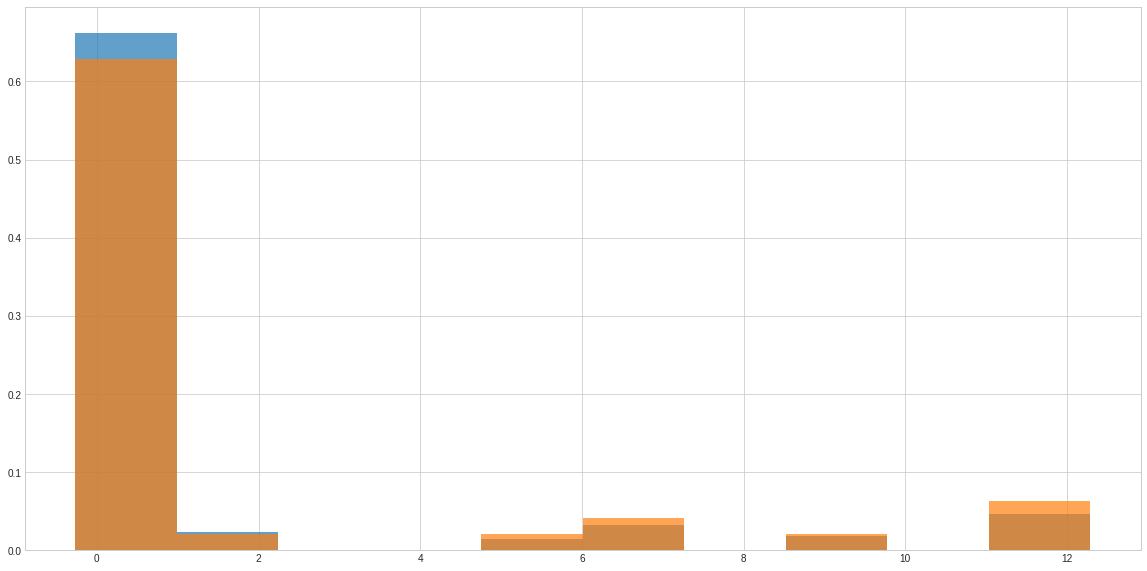

In [9]:
volumes = []
[[[volumes.append(volume) for volume in method[-2].values] for method in split]for split in bar_plot]
plt.hist(volumes, normed=True, alpha=0.7)
plt.hist(X[y]['volume'], normed=True, alpha=0.7)

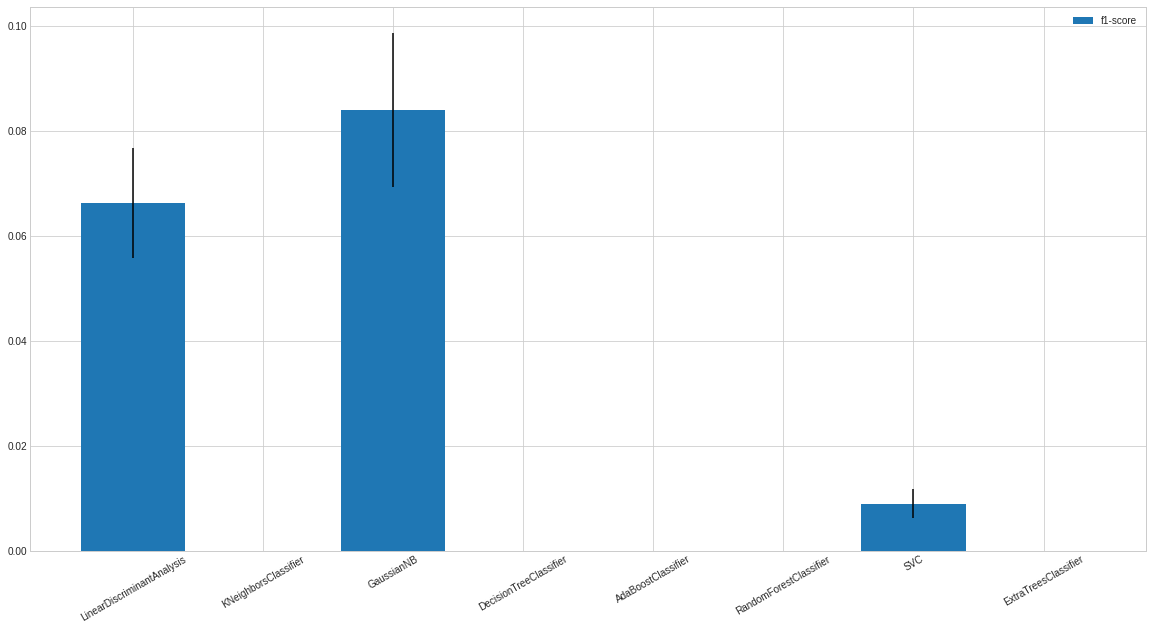

In [10]:
x = np.arange(len(f1s))
plt.bar(x, f1s, yerr=f1s_err, label='f1-score')

plt.xticks(x, labels, rotation=30)
plt.legend()

In [11]:
i_max = np.argmax(f1s)

print(f'ADASYN ({labels[i_max]}):', f1s[i_max], '+/-' ,f1s_err[i_max])

ADASYN (GaussianNB): 0.08401162525335912 +/- 0.01471298352950665
